In [1]:
import tensorflow as tf
from keras.layers import Dense, Input
from keras.models import Model
from keras.callbacks import EarlyStopping


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import mplhep

import zfit

# mplhep.style.use("LHCb2")

import modplot
import numpy as np
import pandas as pd

import uproot



import energyflow as ef
import energyflow.archs
import omnifold

gpus = tf.config.experimental.list_physical_devices('GPU')

2024-02-23 12:36:38.533362: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-23 12:36:38.659528: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-23 12:36:39.856545: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/prozorov/install/miniconda3/envs/tf/lib/python3.11/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress 

In [2]:
%matplotlib inline
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>")

# function for creating axes in the MOD plot style
def axes(ratio_plot=True, figsize=(4,4), gridspec_update=None,
         xlabel='', ylabel=r'Probability Density', ylabel_ratio='Ratio to\nTruth', units='', 
         xlim=(0,1), ylim=(0,1), ylim_ratio=(0.7,1.3),
         xticks=None, yticks=None, xtick_step=None, ytick_step=None, ytick_ratio_step=0.15,
         **kwargs):
    
    # gridspec options
    gridspec_kw = {'height_ratios': (3.5, 1) if ratio_plot else (1,), 'hspace': 0.0}
    if isinstance(gridspec_update, dict):
        gridspec_kw.update(gridspec_update)

    # get subplots
    nsubplots = 2 if ratio_plot else 1
    fig, axes = plt.subplots(nsubplots,  gridspec_kw=gridspec_kw, figsize=figsize)
    if nsubplots == 1:
        axes = [axes]
        
    # axes limits
    for ax in axes:
        ax.set_xlim(*xlim)
    axes[0].set_ylim(*ylim)
    if ratio_plot:
        axes[1].set_ylim(*ylim_ratio)
        
    # axes labels
    if units:
        xlabel = r'{} [{}]'.format(xlabel, units)
        ylabel = r'{} [{}{}]'.format(ylabel, units, r'$^{-1}$')
    axes[-1].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)
    if ratio_plot:
        axes[1].set_ylabel(ylabel_ratio, fontsize=8)
        
    # tick settings
    for ax in axes:
        ax.minorticks_on()
        ax.tick_params(top=True, right=True, bottom=True, left=True, direction='in', which='both')
    if ratio_plot:
        axes[0].tick_params(labelbottom=False)
        axes[1].tick_params(axis='y', labelsize=8)
    
    # tick locations and labels
    if xtick_step is not None:
        xticks_locs = [round(xlim[0] + i*xtick_step, 4) for i in range(1+math.floor((xlim[1]-xlim[0])/xtick_step))]
        axes[-1].set_xticks(xticks_locs)
        if xticks is None:
            axes[-1].set_xticklabels(list(map(str, xticks_locs)))
        else:
            axes[-1].set_xticklabels(xticks)
    if ytick_step is not None:
        yticks_locs = [round(ylim[0] + i*ytick_step, 4) for i in range(1+math.floor((ylim[1]-ylim[0])/ytick_step))]
        axes[0].set_yticks(yticks_locs)
        if yticks is None:
            axes[0].set_yticklabels(list(map(str, yticks_locs)))
        else:
            axes[0].set_yticklabels(yticks)
    if ytick_ratio_step is not None and ratio_plot:
        yticks = [round(ylim_ratio[0] + i*ytick_ratio_step, 4)
                  for i in range(1+round((ylim_ratio[1]-ylim_ratio[0])/ytick_ratio_step))][1:-1]
        axes[1].set_yticks(yticks)
        axes[1].set_yticklabels(list(map(str, yticks)))
    
    return fig, axes

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Define default plot styles  

from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}

In [5]:
# Check Versions
import tensorflow as tf
print(tf.__version__)

2.13.0


# OmniFold


In [6]:
D0masMin = 1.75
D0masMax = 2.0
D0ptMin = 1.0

D0ExpCut = f"(D0mass > {D0masMin}) & (D0mass<{D0masMax}) & (D0_pT>{D0ptMin})"

centralityBins=[0,10]   # corresponds to 0 bin
#centralityBins=[10,40] # corresponds to 1 bin
#centralityBins=[40,80] # corresponds to 2 bin

features = [ "pt","z" , "lambda_1_1", "lambda_1_1half","lambda_1_2","lambda_1_3"]

doRealData = False


## ZFit 
Returns weights for centrality


In [7]:
from hepstats.splot import compute_sweights

obs = zfit.Space('D0mass', limits=(D0masMin, D0masMax))
mu = zfit.Parameter("mu", 1.865, 1.8, 1.92, step_size=0.0001)
sigma = zfit.Parameter("sigma", 0.02, 0.001, 0.3, step_size=0.0001)
lambd = zfit.Parameter("lambda", -3.0)
sig_yield = zfit.Parameter('sig_yield', 5300, 0, 100000,
                                step_size=10)  # step size: default is small, use appropriate
bkg_yield = zfit.Parameter('bkg_yield', 25000, 0, 3e5, step_size=10)

def getSWeights(exp):
# model building, pdf creation
    signal_pdf  = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)
    comb_bkg_pdf  = zfit.pdf.Exponential(lambd, obs=obs)

    data= zfit.Data.from_pandas(exp)

# Create the extended models
    extended_sig = signal_pdf.create_extended(sig_yield)
    extended_bkg = comb_bkg_pdf.create_extended(bkg_yield)

# The final model is the combination of the signal and backgrond PDF
    model = zfit.pdf.SumPDF([extended_bkg, extended_sig])

# plot the data
    data_mass = data["D0mass"].numpy()

# Builds the loss.
    data_sw = zfit.Data.from_numpy(obs=obs, array=data_mass)
    nll_sw = zfit.loss.ExtendedUnbinnedNLL(model, data_sw)

# This parameter was useful in the simultaneous fit but not anymore so we fix it.
    sigma.floating = False

# Minimizes the loss.
    minimizer = zfit.minimize.Minuit(use_minuit_grad=True)
    result_sw = minimizer.minimize(nll_sw)
   
    weights = compute_sweights(model, data_sw)
    return weights[sig_yield]


def getEfficiencyD0Yield(pT, centrality):
    # 2014 efficiency
    #                   0-10% ,  10-20% , 20-40% , 40-60% ,  60-80%
    efficiencies = [ [0.000622, 0.000740, 0.00088, 0.00108, 0.00140],         #for pT in range 0-0.5
                     [0.000717, 0.000717, 0.00110, 0.00143, 0.00160],         #for pT in range 0.5-1.0
                     [0.001025, 0.001300, 0.00195, 0.00304, 0.00289],         #for pT in range 1.0-1.5
                     [0.002248, 0.003014, 0.00411, 0.00610, 0.00528],         #for pT in range 1.5-2.0
                     [0.003794, 0.006104, 0.00738, 0.01072, 0.00997],         #for pT in range 2.0-2.5
                     [0.006107, 0.009671, 0.01006, 0.01606, 0.01447],         #for pT in range 2.5-3.0
                     [0.011249, 0.016457, 0.02087, 0.02565, 0.02482],         #for pT in range 3.0-4.0
                     [0.015830, 0.023905, 0.02984, 0.03553, 0.03663],         #for pT in range 4.0-5.0
                     [0.026520, 0.034723, 0.04134, 0.04656, 0.04032],         #for pT in range 5.0-6.0
                     [0.029904, 0.040095, 0.04888, 0.05334, 0.05080],         #for pT in range 6.0-8.0
                     [0.032680, 0.045229, 0.05514, 0.06017, 0.05685] ]        #for pT in range 8.0-30
    
    ptBins = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 8.0, 40]
    centBins = [0, 10, 20, 40, 60, 80]
    pT_range = 0
    centr_range = 0
    for i in range(len(ptBins)):
        if pT >= ptBins[i] and pT < ptBins[i+1]:
            pT_range = i
            break
    for i in range(len(centBins)):
        if  centrality >= centBins[i] and centrality < centBins[i+1]:
            centr_range = i
            break
    return efficiencies[pT_range][centr_range]

#     //https://inspirehep.net/literature/2051708
#     // https://journals.aps.org/prc/abstract/10.1103/PhysRevC.99.034908

# //D0 2014 efficiency                        0-10% ,     10-20% , 20-40% ,  40-60%  60-80%
#     const double efficiencies[11][5]={     {0.000622, 0.000740, 0.00088, 0.00108, 0.00140},         //pT = 0-0.5
#                                            {0.000717,0.000717, 0.00110, 0.00143, 0.00160},          //pT = 0.5-1.0
#                                            {0.001025, 0.001300, 0.00195, 0.00304, 0.00289},         //pT = 1.0-1.5
#                                            {0.002248, 0.003014, 0.00411, 0.00610, 0.00528},         //pT = 1.5-2.0
#                                            {0.003794,0.006104, 0.00738, 0.01072, 0.00997},          //pT = 2.0-2.5
#                                            {0.006107, 0.009671, 0.01006, 0.01606, 0.01447},         //pT = 2.5-3.0
#                                            {0.011249, 0.016457, 0.02087, 0.02565, 0.02482},         //pT = 3.0-4.0
#                                            {0.015830, 0.023905, 0.02984, 0.03553, 0.03663},         //pT = 4.0-5.0
#                                            {0.026520, 0.034723,   0.04134, 0.04656,0.04032},          //pT = 5.0-6.0
#                                            {0.029904, 0.040095,0.04888, 0.05334,0.05080},           //pT = 6.0-8.0
#                                            {0.032680,0.045229,    0.05514,0.06017,0.05685} };         //pT = 8.0-10.0

#     //https://drupal.star.bnl.gov/STAR/system/files/2018_1109_D0spectra_Note.pdf
#     //D0 2016 efficiency                        0-10%       10-20%  20-40%   40-60%      60-80%
#     const double efficiencies2016[11][5] = {  {0.000669, 0.000741, 0.000845, 0.000981, 0.001094},    //pT = 0-0.5
#                                               {0.000741, 0.000707, 0.001018, 0.001216, 0.001305},    //pT = 0.5-1.0
#                                               {0.001037, 0.001285, 0.001957, 0.002952, 0.002222},    //pT = 1.0-1.5
#                                               {0.002358, 0.002978, 0.004169, 0.005517, 0.004192},    //pT = 1.5-2.0
#                                               {0.004128, 0.006111, 0.007096, 0.009658, 0.008442},    //pT = 2.0-2.5
#                                               {0.006282, 0.009654, 0.010210, 0.014426, 0.012034},    //pT = 2.5-3.0
#                                               {0.012071, 0.016277, 0.020178, 0.024096, 0.020480},    //pT = 3.0-4.0
#                                               {0.018021, 0.023850, 0.028217, 0.033696, 0.029730},    //pT = 4.0-5.0
#                                               {0.026160, 0.034300, 0.042521, 0.047122, 0.033852},    //pT = 5.0-6.0
#                                               {0.029773, 0.039774, 0.047944, 0.051664, 0.038528},    //pT = 6.0-8.0
#                                               {0.032934, 0.044408, 0.054539, 0.058225, 0.043018} }; //pT = 8.0-10.0
# }


2024-02-23 12:36:44.379969: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-23 12:36:44.380169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-23 12:36:44.380192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-23 12:36:46.752591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-23 12:36:46.752621: I tensorflow/core/co

In [8]:
# with uproot.open("/home/prozorov/dev/star/unfold/JetFinderEfficiency.root") as file:
#     hist=file["JetFinderEfficiency"] #2d histogram
#     eff=hist.to_numpy()

#     values = eff[0]
#     ptBinsEdges = eff[1]

#     print(ptBinsEdges)

#     print(values)
ptBinsEdges =( 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 15, 18, 30)
# centrality : 0-10%,     10-40%,    40-80%
values =  [ [0.8040493,  0.83887934, 0.91436481],
            [0.83531431, 0.87066498, 0.93592894],
            [0.86378964, 0.89502397, 0.94950428],
            [0.8858829,  0.91200534, 0.95879075],
            [0.90171456, 0.92392761, 0.96557282],
            [0.91389318, 0.93324831, 0.97033296],
            [0.92173535, 0.94047693, 0.97348525],
            [0.92743685, 0.94662845, 0.97777634],
            [0.93525452, 0.94907014, 0.97975429],
            [0.94756974, 0.95762499, 0.98211105],
            [0.95040946, 0.96266307, 0.98382422],
            [0.96602388, 0.96608892, 0.98780008],
            [0.96862745, 0.96307934, 0.99102773]
]

def getSimJetFinderEfficiency(pt, centralityBin): #centralityBin = 0 (0-10%) , 1(10-40%) or 2(40-80%)
    ptBin = np.digitize(pt, ptBinsEdges)-1
    if (ptBin<0):
        ptBin=0
    elif (ptBin>=len(values)):
        ptBin=len(values)-1
    return values[ptBin][centralityBin]


## Setup the Datasets

In [9]:

centralityCuts = ["(Centrality >= {}) & (Centrality < {})".format(centralityBins[i], centralityBins[i+1]) for i in range(len(centralityBins)-1)]
nEvents=1000000

# make centrality dependent analysis
print("Processing centrality bin: ", centralityCuts[0])

embedding_tree = uproot.open("/home/prozorov/dev/star/output_jets.root:Jets")
exp_tree       = uproot.open("/home/prozorov/dev/star/OUTPUT_2014_20012024.root:Jets")

exp = exp_tree.arrays(["D0_pT","D0mass", "centrality", "centr_weight", "jet_pt_corr",
                       "z", "lambda_1_1","lambda_1_1half","lambda_1_2","lambda_1_3"], 
                       cut=D0ExpCut, library='pd')
#apply centrality cut
mapCentrality = {0:70, 1:60, 2:50, 3:40, 4:30, 5:20, 6:10, 7:5, 8:0}
exp["centrality"]  = exp["centrality"].apply(lambda x: mapCentrality[x])
jetFilter =(exp["centrality"]>=centralityBins[0]) & (exp["centrality"]<centralityBins[1])
exp = exp.loc[jetFilter]
expcopy = exp.copy()
exp["SWeight"] = getSWeights(expcopy)

print(exp.head())
exp["Eff"] = exp.apply(lambda row: getEfficiencyD0Yield(row["D0_pT"], row["centrality"]), axis=1)
print(exp.head())
exp["Weight"] = exp["SWeight"]*exp["Eff"]*exp["centr_weight"]
print(exp.head())

exp.drop(columns=["SWeight", "Eff", "centr_weight", "D0_pT","D0mass", "centrality"], inplace=True)
exp.rename(columns={"jet_pt_corr": "pt"}, inplace=True)


columns = ["McJetPt", "McJetD0Z", "McJetLambda_1_1", "McJetLambda_1_1half","McJetLambda_1_2","McJetLambda_1_3",
            "RecoJetPt","RecoJetD0Z", "RecoJetLambda_1_1", "RecoJetLambda_1_1half","RecoJetLambda_1_2","RecoJetLambda_1_3","Centrality","Weight"]
sim_mc_reco= embedding_tree.arrays(columns, cut=centralityCuts[0] + "& (RecoJetNConst!=0)", library="pd", entry_stop=nEvents)

centralityBinMap = {0:0, 10:1, 40:2}
sim_mc_reco["Weight"] = sim_mc_reco["McJetPt"].apply( lambda pt: getSimJetFinderEfficiency(pt, centralityBinMap[centralityBins[0]]))

print("Data events: ", len(exp))
print("MC events: ", len(sim_mc_reco))

print(exp.head())


Processing centrality bin:  (Centrality >= 0) & (Centrality < 10)
       D0_pT    D0mass  centrality  centr_weight  jet_pt_corr         z  \
3   1.325599  1.868544           0      0.835513    29.197884  0.045710   
4   1.325599  1.813106           0      0.835513    29.589823  0.045153   
8   2.083829  1.948493           5      0.849466    17.570477  0.119544   
13  3.717934  1.866389           0      0.823147    20.870733  0.178547   
17  2.376184  1.978131           0      0.777055    24.898172  0.096430   

    lambda_1_1  lambda_1_1half  lambda_1_2  lambda_1_3   SWeight  
3     0.430175        0.348704    0.291515    0.217739  1.248423  
4     0.424477        0.344085    0.287653    0.214855 -0.302563  
8     1.011170        0.845190    0.721362    0.552146 -0.454587  
13    0.533946        0.400335    0.308472    0.196662  1.252240  
17    0.790815        0.671502    0.580718    0.455745 -0.455726  
       D0_pT    D0mass  centrality  centr_weight  jet_pt_corr         z  \
3   1.

In [10]:
genMcJets = sim_mc_reco.iloc[:,0:6]
genMcJets.rename(columns={"McJetPt": "pt", "McJetD0Z": "z",  "McJetLambda_1_1": "lambda_1_1", "McJetLambda_1_1half": "lambda_1_1half", "McJetLambda_1_2": "lambda_1_2", "McJetLambda_1_3": "lambda_1_3"}, inplace=True)
genMcJets["Weight"] = sim_mc_reco["Weight"]

recoMcJets = sim_mc_reco.iloc[:,6:12]
recoMcJets.rename(columns={"RecoJetPt": "pt", "RecoJetD0Z": "z" , "RecoJetLambda_1_1": "lambda_1_1", "RecoJetLambda_1_1half": "lambda_1_1half", "RecoJetLambda_1_2": "lambda_1_2", "RecoJetLambda_1_3": "lambda_1_3"}, inplace=True)
recoMcJets["Weight"] = sim_mc_reco["Weight"] 

assert genMcJets.shape == recoMcJets.shape
assert genMcJets.shape == recoMcJets.shape

print("genMcJets: ", genMcJets.head(20))
print("recoMcJets: ", recoMcJets.head(20))

## Closure test on embedding
trainGen, testGen, trainReco, testReco = train_test_split(genMcJets, recoMcJets, test_size=0.2)

# ## Train on MC, test on data 
# trainGen = genMcJets
# trainReco = recoMcJets
# testReco = exp




genMcJets:             pt         z    lambda_1_1  lambda_1_1half    lambda_1_2  \
13   4.332043  0.942510  3.377420e-02    7.194136e-03  2.089331e-03   
16   6.787934  0.890960  8.479527e-02    2.258711e-02  7.406180e-03   
39   3.019047  1.000000  3.066259e-17    1.073849e-25  3.760778e-34   
44   6.158446  0.690154  3.199627e-01    1.346572e-01  6.290882e-02   
45   2.194314  0.775095  1.120121e-01    2.711296e-02  7.142981e-03   
47   5.860472  0.247135  3.208839e-01    1.462017e-01  6.857074e-02   
51   2.443995  0.512774  4.091412e-01    1.652737e-01  6.680603e-02   
82   1.289757  0.834505  2.599400e-01    1.023278e-01  4.574445e-02   
94   1.351508  1.000000  8.233160e-18    1.494101e-26  2.711397e-35   
95   3.620003  0.929971  3.221424e-02    6.192002e-03  1.575417e-03   
96   8.257239  0.595294  2.438712e-01    9.174751e-02  3.913308e-02   
97   5.518092  0.909288  1.105838e-02    7.712862e-04  5.379472e-05   
100  3.120220  0.525854  5.358506e-01    2.484886e-01  1.155148e-

## Unfold Data

In [11]:
iterations = 4

In [22]:
model_layer_sizes = [100, 100]
# model_layer_sizes = [100, 100, 100] # use this for the full network size

# set up the array of data/simulation detector-level observables
scaler = StandardScaler()

X_det = scaler.fit_transform((pd.concat([testReco[features], trainReco[features]], ignore_index=True, sort=False)))
X_gen = scaler.fit_transform((pd.concat([trainGen[features], trainGen[features]], ignore_index=True, sort=False)))

Y_det = tf.keras.utils.to_categorical(np.concatenate((np.ones(testReco.shape[0]), np.zeros(trainReco.shape[0]))))
Y_gen = tf.keras.utils.to_categorical(np.concatenate((np.ones(trainGen.shape[0]), np.zeros(trainGen.shape[0]))))


# Specify the training parameters
# model parameters for the Step 1 network
det_args = {'input_dim': len(features), 'dense_sizes': model_layer_sizes,
            'patience': 10, 'filepath': 'Step1_{}', 'save_weights_only': False, 
            'modelcheck_opts': {'save_best_only': True, 'verbose': 1}}

# model parameters for the Step 2 network
mc_args = {'input_dim': len(features), 'dense_sizes': model_layer_sizes, 
           'patience': 10, 'filepath': 'Step2_{}', 'save_weights_only': False, 
           'modelcheck_opts': {'save_best_only': True, 'verbose': 1}}

# general training parameters
fitargs = {'batch_size': 500, 'epochs': 2, 'verbose': 1}
#fitargs = {'batch_size': 500, 'epochs': 100, 'verbose': 1} # use this for a full training

# reweight the sim and data to have the same total weight to begin with
ndata, nsim = np.count_nonzero(Y_det[:,1]), np.count_nonzero(Y_det[:,0])
wdata = np.ones(ndata)
winit = ndata/nsim*np.ones(nsim)

In [23]:

# apply the OmniFold procedure to get weights for the generation
multifold_ws = omnifold.omnifold(X_gen, Y_gen, X_det, Y_det, wdata, winit,
                                (ef.archs.DNN, det_args), (ef.archs.DNN, mc_args),
                                fitargs, val=0.1, it=iterations, trw_ind=-2, weights_filename='Test')

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 6)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               700       
                                                                 
 activation_24 (Activation)  (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 activation_25 (Activation)  (None, 100)               0         
                                                                 
 output (Dense)              (None, 2)                 202       
                                                                 
 activation_26 (Activation)  (None, 2)                 0   

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 6)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               700       
                                                                 
 activation_27 (Activation)  (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 activation_28 (Activation)  (None, 100)               0         
                                                                 
 output (Dense)              (None, 2)                 202       
                                                                 
 activation_29 (Activation)  (None, 2)                 0   

/home/prozorov/dev/star/unfold/Tanmay/omnifold.py:31: RuntimeWarning: divide by zero encountered in divide
  w *= np.clip(preds/(1 - preds + 10**-50), fitargs.get('weight_clip_min', 0.), fitargs.get('weight_clip_max', 1))


Epoch 1/2
424/428 [============================>.] - ETA: 0s - loss: 0.1763 - acc: 0.4984
Epoch 1: val_loss improved from inf to 0.17648, saving model to Step2_2_Epoch-1
428/428 [==============================] - 4s 8ms/step - loss: 0.1763 - acc: 0.4985 - val_loss: 0.1765 - val_acc: 0.5000
Epoch 2/2
427/428 [============================>.] - ETA: 0s - loss: 0.1762 - acc: 0.4980
Epoch 2: val_loss improved from 0.17648 to 0.17615, saving model to Step2_2_Epoch-2
5/5 [==============================] - 0s 4ms/step
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 6)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               700       
                                                                 
 activation_42 (Activation)  (None, 100)               0         
    

/tmp/ipykernel_103219/4008819328.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


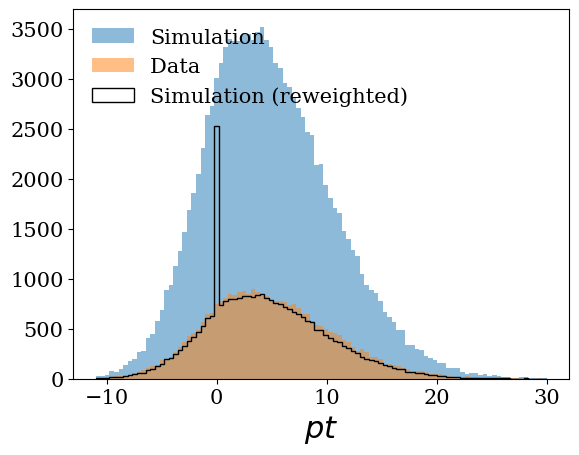

In [24]:
wdata = multifold_ws[2*iterations-1] #weights after last iteration for pull after step 1
bins = np.linspace(-11, 30, 100)

fig =plt.gcf()
ax = plt.gca()
ax.set_xlabel('$pt$')
ax.hist(trainReco["pt"], bins=bins, **plot_style_2, label='Simulation')
ax.hist(testReco["pt"], bins=bins, **plot_style_2, label='Data ')
ax.hist(trainReco["pt"], bins=bins, histtype="step", label='Simulation (reweighted)',color="black",weights=wdata)
legend = ax.legend(
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()
plt.savefig("plot_datareweight.pdf")

Done with pt
Done with z
Done with lambda_1_1
Done with lambda_1_1half
Done with lambda_1_2
Done with lambda_1_3


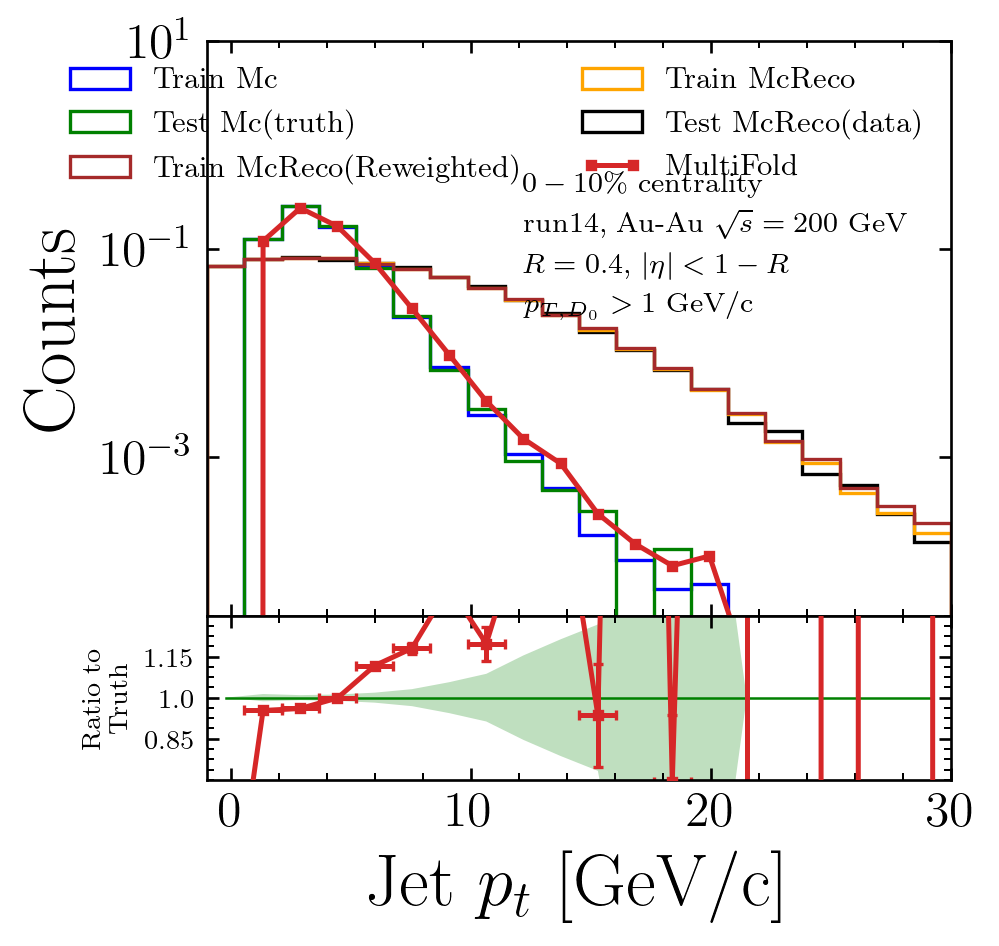

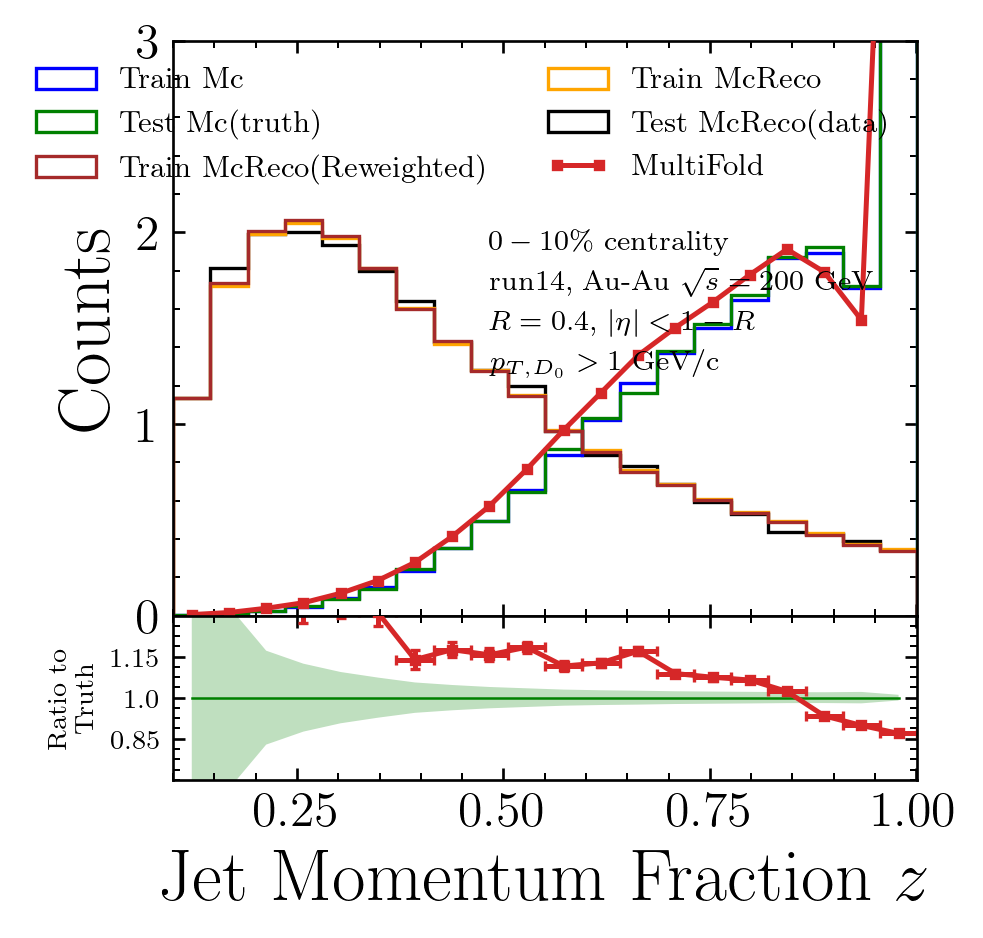

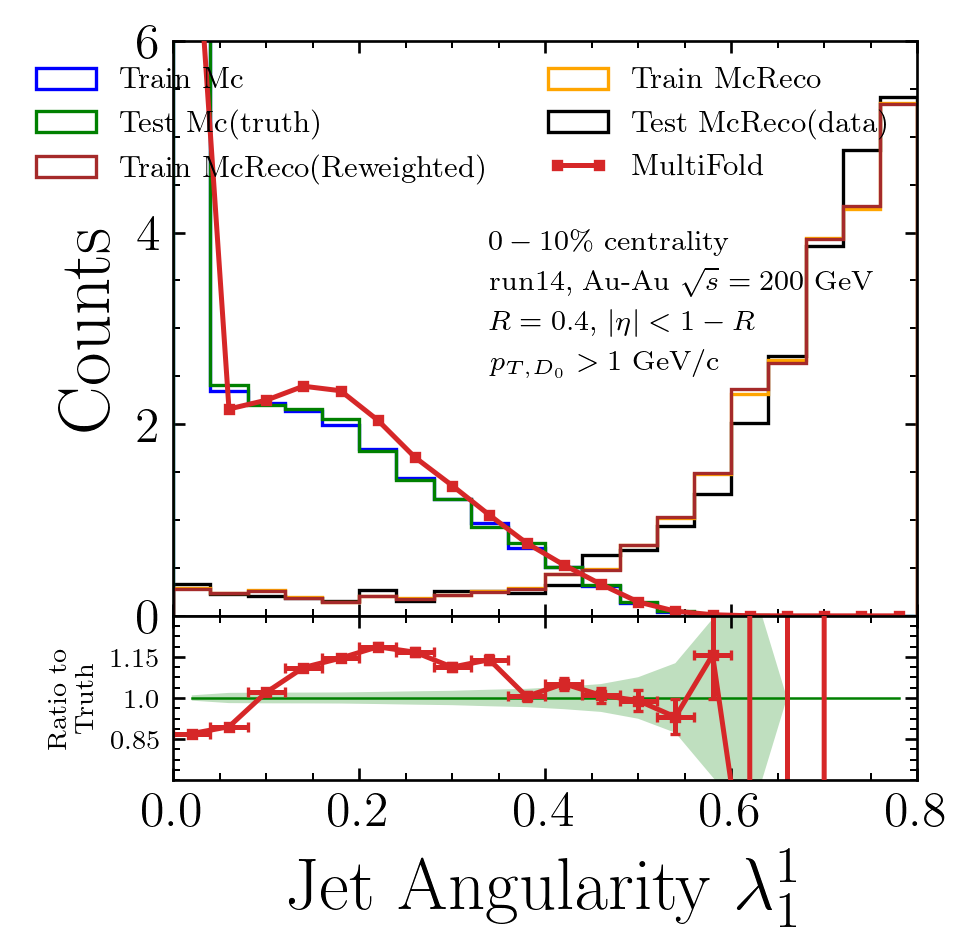

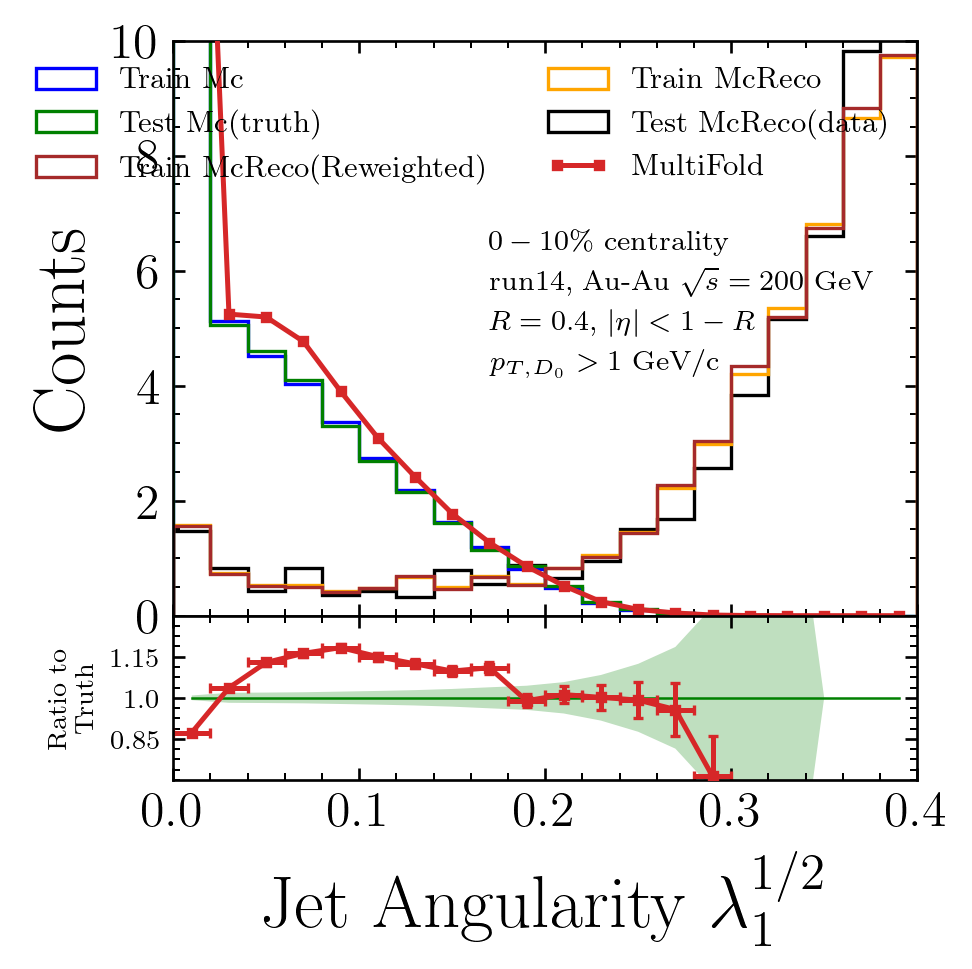

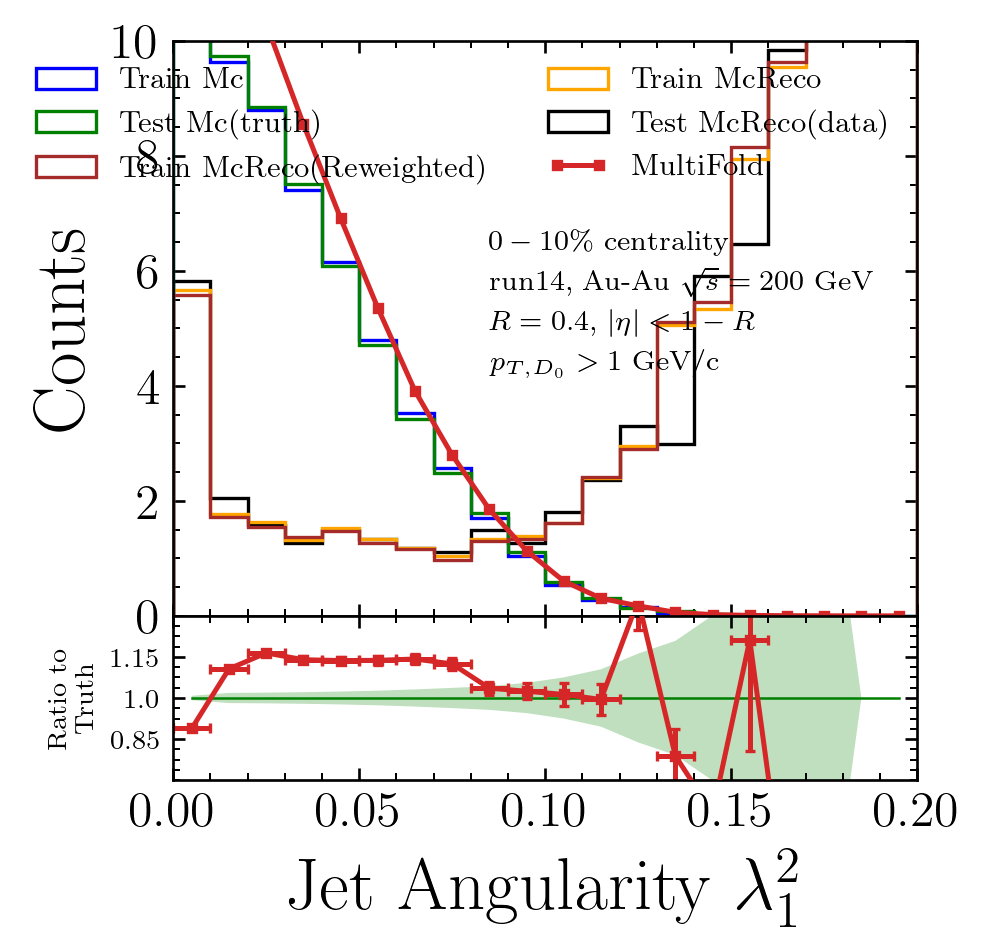

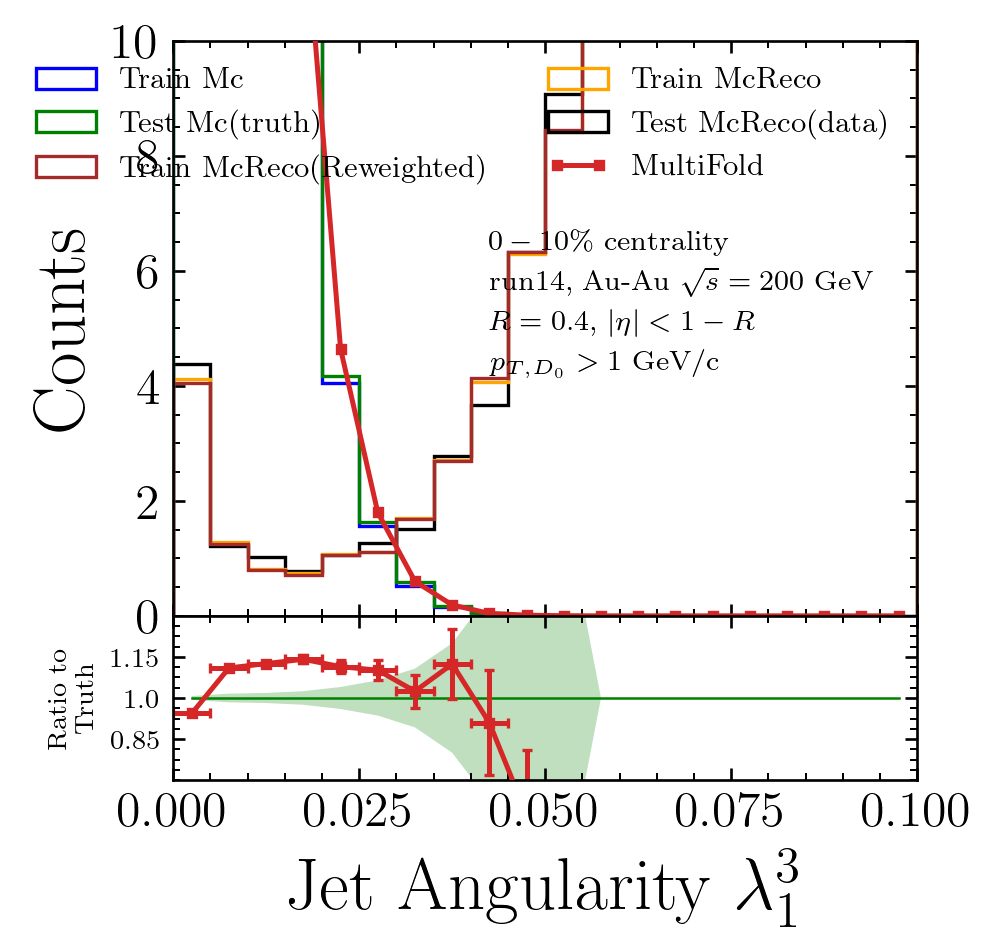

In [25]:
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['figure.dpi'] = 240
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "Helvetica",
})


# a dictionary to hold information about the observables
obs = {}
# the jet mass and histogram style information
obs.setdefault('pt', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (-1, 30),  'ylim': (0.00003, 10),
    'xlabel': r'Jet $p_{t}$  [GeV/c]', 'symbol': r'$p_{t}$',
    'ylabel': r'Counts', 'yscale': 'log',
    'stamp_xy': (0.425, 0.75),
})

# the groomed momentum fraction and histogram style information
obs.setdefault('z', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0.1, 1.001),   'ylim': (0, 3),
    'xlabel': r'Jet Momentum Fraction $z$', 'symbol': r'$z$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_1', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0, 0.8),  'ylim': (0, 6),
    'xlabel': r'Jet Angularity $\lambda_{1}^{1}$', 'symbol': r'$lambda_1_1$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_1half', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0, 0.4),  'ylim': (0, 10),
    'xlabel': r'Jet Angularity $\lambda_{1}^{1/2}$', 'symbol': r'$lambda_1_1half$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_2', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0, 0.2),  'ylim': (0, 10),
    'xlabel': r'Jet Angularity $\lambda_{1}^{2}$', 'symbol': r'$lambda_1_2$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_3', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0, 0.1),  'ylim': (0, 10),
    'xlabel': r'Jet Angularity $\lambda_{1}^{3}$', 'symbol': r'$lambda_1_3$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})


# additional histogram and plot style information
hist_style = {'histtype': 'step', 'density': True, 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '--', 'color': 'blue', 'lw': 1.15, 'label': 'Gen.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': '``Truth\"'}
omnifold_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:red', 'zorder': 3}


for obkey,ob in obs.items():
        # calculate observable for GEN, SIM, DATA
    ob['genobs'] = trainGen[obkey].to_numpy()
    ob['simobs'] = trainReco[obkey].to_numpy()

    ob['truthobs'] = testGen[obkey].to_numpy()
    ob['dataobs'] = testReco[obkey].to_numpy()

 # setup bins
    ob['bins_det'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_det']+1)
    ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    ob['midbins_det'] = (ob['bins_det'][:-1] + ob['bins_det'][1:])/2
    ob['midbins_mc'] = (ob['bins_mc'][:-1] + ob['bins_mc'][1:])/2
    ob['binwidth_det'] = ob['bins_det'][1] - ob['bins_det'][0]
    ob['binwidth_mc'] = ob['bins_mc'][1] - ob['bins_mc'][0]



    # get the histograms of GEN, DATA, and SIM level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'])[0]
    ob['simobs_hist'] = np.histogram(ob['simobs'], bins=ob['bins_det'])[0]
    ob['data_hist']   = np.histogram(ob['dataobs'], bins=ob['bins_det'])[0]
  
    ob['truth_hist'], ob['truth_hist_unc'] = modplot.calc_hist(ob['truthobs'], bins=ob['bins_mc'], 
                                                               density=True)[:2]
  
   
    print('Done with', obkey)


for i,(obkey,ob) in enumerate(obs.items()):
    
    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob)
    if ob.get('yscale') is not None:
        ax0.set_yscale(ob['yscale'])


    # Plot the Different Distributions of the Observable
    # plot the "data" histogram of the observable
    ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='Test McReco(data)', **hist_style)

    # plot the "sim" histogram of the observable
    ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='Train McReco', **hist_style)

    ax0.hist(ob['genobs'], bins=ob['bins_mc'], color='blue', label='Train Mc', **hist_style)

    # plot the "sim" histogram of the observable
    ax0.hist(ob['truthobs'], bins=ob['bins_mc'], color='green', label='Test Mc(truth)', **hist_style)

    # plot the "sim" histogram of the observable
    ax0.hist(ob['simobs'], bins=ob['bins_det'], color='brown', weights=multifold_ws[2*iterations], label='Train McReco(Reweighted)', **hist_style)

    # # # plot the "gen" histogram of the observable
    # ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)

    # # plot the "truth" histogram of the observable
    # ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)

    
    # Plot the Unfolded Distributions of the Observable
    # plot the OmniFold distribution
    of_histgen, of_histgen_unc = modplot.calc_hist(ob['genobs'], weights=multifold_ws[2*iterations], bins=ob['bins_mc'], density=True)[:2]
    ax0.plot(ob['midbins_mc'], of_histgen, **omnifold_style, label='MultiFold')

    # Plot the Ratios of the OmniFold distribution to truth (with statistical uncertainties)

    of_ratio = of_histgen/(ob['truth_hist']+ 10**-50)
    ax1.plot(ob['midbins_mc'], of_ratio, **omnifold_style)

    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    
    # ratio uncertainties
    truth_unc_ratio = ob['truth_hist_unc']/(ob['truth_hist'] + 10**-50)

    of_unc_ratio = of_histgen_unc/(ob['truth_hist'] + 10**-50)
    
    ax1.fill_between(ob['midbins_mc'], 1 - truth_unc_ratio, 1 + truth_unc_ratio, 
                     facecolor=truth_style['facecolor'], zorder=-2)

    ax1.errorbar(ob['midbins_mc'], of_ratio, xerr=ob['binwidth_mc']/2, yerr=of_unc_ratio, 
                                              color=omnifold_style['color'], **modplot.style('errorbar'))

    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    order = [2, 3, 4, 1, 0,5] 
    modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol,fontsize = 9)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.07, ax=ax0,
                  line_0=r'$0-10 \%$ centrality',
                  line_1=r'run14, Au-Au $\sqrt{s}=200$ GeV',
                  line_2=r'$R=0.4$, $|\eta|<1-R$',
                  line_3=r'$p_{T,D_0}>1$ GeV/c')


    # save plot (by default in the same directory as this notebook).
    # If running on binder, the plot can be accessed by first going to the jupyter file browser
    # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
    # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
    fig.savefig('MultiFold_{}.pdf'.format(obkey), bbox_inches='tight')
    plt.show()
